In [1]:
%pip install transformers
%pip install nltk
%pip install tabulate

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
#from nltk.corpus import stopwords
import nltk
import re
from tabulate import tabulate
from tqdm import trange

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

In [3]:
#verificare la disponibilità di cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
#leggi csv

# Percorso del file CSV
file_path = '/content/drive/MyDrive/b/csv/train.csv'

# Leggi il file CSV con i nomi personalizzati delle colonne
df = pd.read_csv(file_path)
df = df.dropna()
df['sentiment'] = df['sentiment'].replace({'neg': 0, 'pos': 1})

df.head()

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",0
1,"The saddest thing about this ""tribute"" is that...",0
2,Last night I decided to watch the prequel or s...,0
3,I have to admit that i liked the first half of...,0
4,I was not impressed about this film especially...,0


In [7]:
#elimina stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('english')

def clean_text(text):

    text = text.lower()

    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs
    #text = re.sub(r"http", "",text)

    html=re.compile(r'<.*?>')

    text = html.sub(r'',text) #Removing html tags

    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations

    text = [word.lower() for word in text.split() if word.lower() not in sw]

    text = " ".join(text) #removing stopwords

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
#applica puliziz di stop words
df['text'] = df['text'].apply(lambda x: clean_text(x))
df.head()

,text,sentiment
0,"now, deny purchased ebay, high expectations in...",0
1,saddest thing tribute almost singers including...,0
2,last night decided watch prequel shall say cal...,0
3,"admit liked first half sleepers looked good, a...",0
4,impressed film especially fact went cinema fam...,0


## Split dataset in train e test

In [10]:
from sklearn.model_selection import train_test_split

# Divide il DataFrame in insiemi di addestramento e test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Resetta gli indici dei DataFrame
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Numero di righe nel DataFrame di addestramento
num_train_rows = train_df.shape[0]
print("Numero di righe nel DataFrame di addestramento:", num_train_rows)

# Numero di righe nel DataFrame di test
num_test_rows = test_df.shape[0]
print("Numero di righe nel DataFrame di test:", num_test_rows)


# Visualizza le prime righe del DataFrame di addestramento
print("Train DataFrame:")
print(train_df.head())

# Visualizza le prime righe del DataFrame di test
print("\nTest DataFrame:")
print(test_df.head())


Numero di righe nel DataFrame di addestramento: 20000
Numero di righe nel DataFrame di test: 5000
Train DataFrame:
                                                text  sentiment
0  really watch movie girlfriend romantic mood, l...          0
1  reasons taking documentary serious four reason...          0
2  never heard film came across accident browsing...          1
3  care bears movie new generation bad movie fact...          1
4  read schneebaum book title film first publishe...          1

Test DataFrame:
                                                text  sentiment
0  woman sylvia kristel seduces year old boy eric...          0
1  passing stones definitely one best comedy inde...          1
2  concept sarafina appears sound one, aside musi...          0
3  original cube fantastic b movie rich paranoia,...          0
4  sowe get see added footage brandointeresting e...          0


## Prepoccessing input

In [11]:
train_text = train_df.text.values
train_labels = train_df.sentiment.values

test_text = test_df.text.values
test_labels = test_df.sentiment.values

In [12]:
#token
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
##mostra token per il train

index=100
index=709
print(' Original: ', train_text[index])

table = np.array([tokenizer.tokenize(train_text[index]),
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text[index]))]).T
print(tabulate(table,headers = ['Tokens', 'Token IDs'],tablefmt = 'fancy_grid'))

 Original:  match tag team table match bubba ray spike dudley vs eddie guerrero chris benoit bubba ray spike dudley started things tag team table match eddie guerrero chris benoit according rules match, opponents go tables order get win benoit guerrero heated early taking turns hammering first spike bubba ray german suplex benoit bubba took wind dudley brother spike tried help brother, referee restrained benoit guerrero ganged corner benoit stomping away bubba, guerrero set table outside spike dashed ring somersaulted top rope onto guerrero outside recovering taking care spike, guerrero slipped table ring helped wolverine set tandem set double superplex middle rope would put bubba table, spike knocked table right brother came crashing guerrero benoit propped another table corner tried irish whip spike it, bubba dashed blocked brother bubba caught fire lifted opponents back body drops bubba slammed guerrero spike stomped wolverine top rope bubba held benoit bay spike soar wassup headbut

In [14]:
max_len = 0
total_length = 0
num_sentences = len(train_text)

# For every sentence...
for sent in train_text:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Aggiorna la somma totale delle lunghezze delle frasi
    total_length += len(input_ids)

    # Aggiorna la lunghezza massima
    max_len = max(max_len, len(input_ids))

# Calcola la lunghezza media
average_length = total_length / num_sentences

print('Max sentence length:', max_len)
print('Average sentence length:', average_length)


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


Max sentence length: 1772
Average sentence length: 155.50145


In [15]:
#siccome la max_length supera i 512, consentit da bert la fissiamo noi in modo da troncare a 156 (lunghezza media) quelli più lunghi

input_ids = []
attention_masks = []

# For every tweet...
for t in train_text:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        t,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = round(average_length),           # Pad & truncate all sentences.
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train_labels)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
# Print sentence 0, now as a list of IDs.
i=random.randint(0,len(train_text)-1)
#i=709
#i=100
print('Original: ', train_text[i])
print('Input IDs:', input_ids[i])

input_ids_list = input_ids[i].tolist()



Original:  sure, history movie hollywoodized far bit history rewritten masses lafitte sided americans considered frenchman therefore hated british, sense patriotism nation taken new orleans short time ago broke agreement returned smuggling, caused sailing galveston petty criminal scoundrel hero swashbuckler cares one movie sheer entertainment face it, wanted jean go feisty wench rather prudish daughter governor brynner rises mediocre writing give fascinating performance
Input IDs: tensor([  101,  2469,  1010,  2381,  3185,  5365,  3550,  2521,  2978,  2381,
         2128, 15773, 11678,  2474,  8873,  4674, 11536,  4841,  2641, 26529,
         3568,  6283,  2329,  1010,  3168, 16419,  2964,  3842,  2579,  2047,
         5979,  2460,  2051,  3283,  3631,  3820,  2513, 19535,  1010,  3303,
         8354, 26630, 11612,  4735,  8040, 28819, 16570,  5394, 25430, 11823,
        24204,  3917, 14977,  2028,  3185, 11591,  4024,  2227,  2009,  1010,
         2359,  3744,  2175, 24664, 21756, 191

In [17]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(train_text) - 1)
  #index=709
  tokens = tokenizer.tokenize(tokenizer.decode(input_ids[index]))
  token_ids = [i.numpy() for i in input_ids[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(train_text[index])
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

starts bad, three women acting like simpering junior high school wussies sitting around giggling gin, endless cigarettes caramel chocolate treat one tells best man story, gets worse spoiler alert andie character falling young organ player used student headmistress english school, believe , destroyed thanks bitch hell girlfriend there, basically unwatchable claptrap forgives friend organ player love child women end started, drinking gin smoking cigarettes blah blah blah andie character throws caramel chocolates street, pathetic attempt symbolize growth mercy
╒════════════╤═════════════╤══════════════════╕
│ Tokens     │   Token IDs │   Attention Mask │
╞════════════╪═════════════╪══════════════════╡
│ [CLS]      │         101 │                1 │
├────────────┼─────────────┼──────────────────┤
│ starts     │        4627 │                1 │
├────────────┼─────────────┼──────────────────┤
│ bad        │        2919 │                1 │
├────────────┼─────────────┼──────────────────┤
│ , 

In [18]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
#val_size = int(0.2 * len(dataset))
val_size = len(dataset)  - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

16,000 training samples
4,000 validation samples


Train parameters
The optimal hyperparameter values are task-specific, but we found the following range of possible values to work well across all tasks:

- Batch size: 16, 32

- Learning rate (Adam): 5e-5, 3e-5, 2e-5

- Number of epochs: 2, 3, 4

In [19]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Some Prediction Metrics

In [20]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

## Create BERT model

In [21]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# if device == "cuda:0":
# # Tell pytorch to run this model on the GPU.
#     model = model.cuda()
model = model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [24]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
epochs = 4

for _ in trange(epochs, desc = 'Epoch'):

    # ========== Training ==========

    # Set model to training mode
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids,
                             token_type_ids = None,
                             attention_mask = b_input_mask,
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids,
                              token_type_ids = None,
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


Epoch:  25%|██▌       | 1/4 [07:10<21:32, 430.97s/it]


	 - Train loss: 0.3538
	 - Validation Accuracy: 0.8882
	 - Validation Precision: 0.9129
	 - Validation Recall: 0.8636
	 - Validation Specificity: 0.9147



Epoch:  50%|█████     | 2/4 [14:24<14:25, 432.58s/it]


	 - Train loss: 0.2140
	 - Validation Accuracy: 0.8822
	 - Validation Precision: 0.9259
	 - Validation Recall: 0.8355
	 - Validation Specificity: 0.9329



Epoch:  75%|███████▌  | 3/4 [21:38<07:13, 433.22s/it]


	 - Train loss: 0.1211
	 - Validation Accuracy: 0.8865
	 - Validation Precision: 0.8757
	 - Validation Recall: 0.9028
	 - Validation Specificity: 0.8707



Epoch: 100%|██████████| 4/4 [28:52<00:00, 433.09s/it]


	 - Train loss: 0.0643
	 - Validation Accuracy: 0.8895
	 - Validation Precision: 0.9055
	 - Validation Recall: 0.8740
	 - Validation Specificity: 0.9071



## Test2

In [33]:

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for t in test_text:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        t,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = round(average_length),           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )


    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [34]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 5,000 test sentences...
    DONE.


In [42]:
from functools import reduce
scores = reduce(lambda x,y: x+y,[list(map(np.argmax,p)) for p in predictions])
labels = reduce(lambda x,y: list(x) + list(y), true_labels)

from sklearn.metrics import precision_score, recall_score, f1_score
accuracy = accuracy_score(scores, labels)
print("Accuracy:", accuracy)

# Calcola la precision
precision = precision_score(labels, scores)
print("Precision:", precision)

# Calcola la recall
recall = recall_score(labels, scores)
print("Recall:", recall)

# Calcola l'F1-score
f1 = f1_score(labels, scores)
print("F1-score:", f1)

Accuracy: 0.8752
Precision: 0.8803905614320586
Recall: 0.867682437850842
F1-score: 0.8739903069466882


##Matrice di confusione

In [47]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

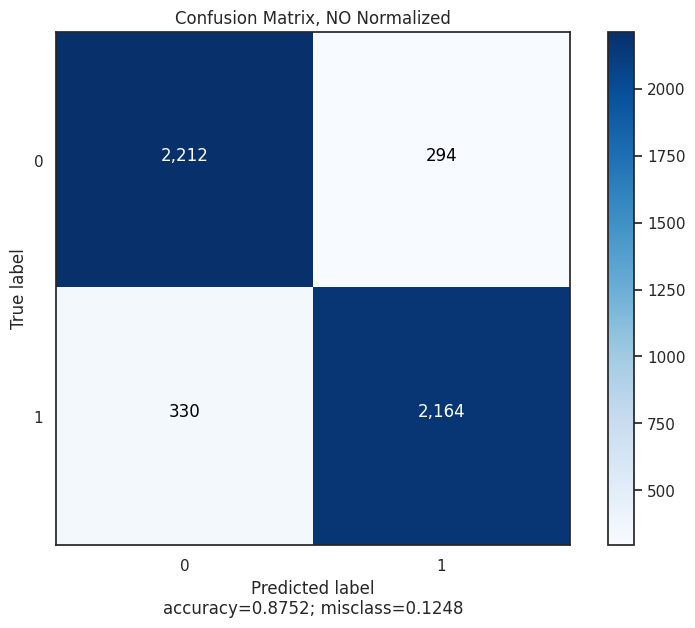

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.set(font_scale=1)
sns.set(style='white')


cm = confusion_matrix(labels,scores)
plot_confusion_matrix(cm           = cm,
                      normalize    = False,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix, NO Normalized")